# Mini Project: Dynamic Programming

In this notebook, you will write your own implementations of many classical dynamic programming algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore FrozenLakeEnv

Use the code cell below to create an instance of the [FrozenLake](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) environment.

In [10]:
!pip install -q matplotlib==2.2.2
from frozenlake import FrozenLakeEnv

env = FrozenLakeEnv()

The agent moves through a $4 \times 4$ gridworld, with states numbered as follows:
```
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
```
and the agent has 4 potential actions:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [11]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


Dynamic programming assumes that the agent has full knowledge of the MDP.  We have already amended the `frozenlake.py` file to make the one-step dynamics accessible to the agent.  

Execute the code cell below to return the one-step dynamics corresponding to a particular state and action.  In particular, `env.P[1][0]` returns the the probability of each possible reward and next state, if the agent is in state 1 of the gridworld and decides to go left.

In [12]:
env.P[1][0]

[(0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 5, 0.0, True)]

Each entry takes the form 
```
prob, next_state, reward, done
```
where: 
- `prob` details the conditional probability of the corresponding (`next_state`, `reward`) pair, and
- `done` is `True` if the `next_state` is a terminal state, and otherwise `False`.

Thus, we can interpret `env.P[1][0]` as follows:
$$
\mathbb{P}(S_{t+1}=s',R_{t+1}=r|S_t=1,A_t=0) = \begin{cases}
               \frac{1}{3} \text{ if } s'=1, r=0\\
               \frac{1}{3} \text{ if } s'=0, r=0\\
               \frac{1}{3} \text{ if } s'=5, r=0\\
               0 \text{ else}
            \end{cases}
$$

To understand the value of `env.P[1][0]`, note that when you create a FrozenLake environment, it takes as an (optional) argument `is_slippery`, which defaults to `True`.  

To see this, change the first line in the notebook from `env = FrozenLakeEnv()` to `env = FrozenLakeEnv(is_slippery=False)`.  Then, when you check `env.P[1][0]`, it should look like what you expect (i.e., `env.P[1][0] = [(1.0, 0, 0.0, False)]`).

The default value for the `is_slippery` argument is `True`, and so `env = FrozenLakeEnv()` is equivalent to `env = FrozenLakeEnv(is_slippery=True)`.  In the event that `is_slippery=True`, you see that this can result in the agent moving in a direction that it did not intend (where the idea is that the ground is *slippery*, and so the agent can slide to a location other than the one it wanted).

Feel free to change the code cell above to explore how the environment behaves in response to other (state, action) pairs.  

Before proceeding to the next part, make sure that you set `is_slippery=True`, so that your implementations below will work with the slippery environment!

### Part 1: Iterative Policy Evaluation

In this section, you will write your own implementation of iterative policy evaluation.

Your algorithm should accept four arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used to decide if the estimate has sufficiently converged to the true value function (default value: `1e-8`).

The algorithm returns as **output**:
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s` under the input policy.

Please complete the function in the code cell below.

In [20]:
import numpy as np

def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    
    ## TODO: complete the function
    while True:
        delta = 0
        for s in range(env.nS):
            Vs = 0
            
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
                
            delta = max(delta, np.abs(V[s] - Vs))
            V[s] = Vs
        
        if delta < theta:
            break
                
    return V

We will evaluate the equiprobable random policy $\pi$, where $\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}$ for all $s\in\mathcal{S}$ and $a\in\mathcal{A}(s)$.  

Use the code cell below to specify this policy in the variable `random_policy`.

In [21]:
random_policy = np.ones([env.nS, env.nA]) / env.nA

Run the next code cell to evaluate the equiprobable random policy and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

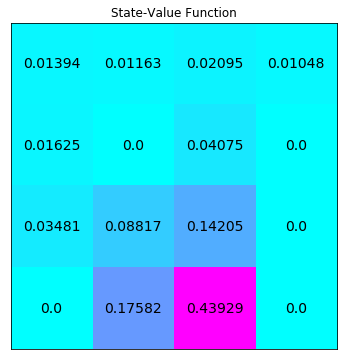

In [22]:
from plot_utils import plot_values

# evaluate the policy 
V = policy_evaluation(env, random_policy)

plot_values(V)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that your `policy_evaluation` function satisfies the requirements outlined above (with four inputs, a single output, and with the default values of the input arguments unchanged).

In [23]:
import check_test

check_test.run_check('policy_evaluation_check', policy_evaluation)

**<span style="color: green;">PASSED</span>**

### Part 2: Obtain $q_\pi$ from $v_\pi$

In this section, you will write a function that takes the state-value function estimate as input, along with some state $s\in\mathcal{S}$.  It returns the **row in the action-value function** corresponding to the input state $s\in\mathcal{S}$.  That is, your function should accept as input both $v_\pi$ and $s$, and return $q_\pi(s,a)$ for all $a\in\mathcal{A}(s)$.

Your algorithm should accept four arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `s`: This is an integer corresponding to a state in the environment.  It should be a value between `0` and `(env.nS)-1`, inclusive.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `q`: This is a 1D numpy array with `q.shape[0]` equal to the number of actions (`env.nA`).  `q[a]` contains the (estimated) value of state `s` and action `a`.

Please complete the function in the code cell below.

In [ ]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    
    ## TODO: complete the function
    
    return q

Run the code cell below to print the action-value function corresponding to the above state-value function.

In [ ]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `q_from_v` function satisfies the requirements outlined above (with four inputs, a single output, and with the default values of the input arguments unchanged).

In [ ]:
check_test.run_check('q_from_v_check', q_from_v)

### Part 3: Policy Improvement

In this section, you will write your own implementation of policy improvement. 

Your algorithm should accept three arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.

Please complete the function in the code cell below.  You are encouraged to use the `q_from_v` function you implemented above.

In [ ]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    
    ## TODO: complete the function

    return policy

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `policy_improvement` function satisfies the requirements outlined above (with three inputs, a single output, and with the default values of the input arguments unchanged).

Before moving on to the next part of the notebook, you are strongly encouraged to check out the solution in **Dynamic_Programming_Solution.ipynb**.  There are many correct ways to approach this function!

In [ ]:
check_test.run_check('policy_improvement_check', policy_improvement)

### Part 4: Policy Iteration

In this section, you will write your own implementation of policy iteration.  The algorithm returns the optimal policy, along with its corresponding state-value function.

Your algorithm should accept three arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used to decide if the policy evaluation step has sufficiently converged to the true value function (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.  You are strongly encouraged to use the `policy_evaluation` and `policy_improvement` functions you implemented above.

In [ ]:
import copy

def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    ## TODO: complete the function

    return policy, V

Run the next code cell to solve the MDP and visualize the output.  The optimal state-value function has been reshaped to match the shape of the gridworld.

**Compare the optimal state-value function to the state-value function from Part 1 of this notebook**.  _Is the optimal state-value function consistently greater than or equal to the state-value function for the equiprobable random policy?_

In [ ]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `policy_iteration` function satisfies the requirements outlined above (with three inputs, two outputs, and with the default values of the input arguments unchanged).

In [ ]:
check_test.run_check('policy_iteration_check', policy_iteration)

### Part 5: Truncated Policy Iteration

In this section, you will write your own implementation of truncated policy iteration.  

You will begin by implementing truncated policy evaluation.  Your algorithm should accept five arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `max_it`: This is a positive integer that corresponds to the number of sweeps through the state space (default value: `1`).
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.

In [ ]:
def truncated_policy_evaluation(env, policy, V, max_it=1, gamma=1):
    
    ## TODO: complete the function
    
    return V

Next, you will implement truncated policy iteration.  Your algorithm should accept five arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `max_it`: This is a positive integer that corresponds to the number of sweeps through the state space (default value: `1`).
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used for the stopping criterion (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.

In [ ]:
def truncated_policy_iteration(env, max_it=1, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA]) / env.nA
    
    ## TODO: complete the function
    
    return policy, V

Run the next code cell to solve the MDP and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

Play with the value of the `max_it` argument.  Do you always end with the optimal state-value function?

In [ ]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `truncated_policy_iteration` function satisfies the requirements outlined above (with four inputs, two outputs, and with the default values of the input arguments unchanged).

In [ ]:
check_test.run_check('truncated_policy_iteration_check', truncated_policy_iteration)

### Part 6: Value Iteration

In this section, you will write your own implementation of value iteration.

Your algorithm should accept three arguments as input:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used for the stopping criterion (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

In [ ]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    
    ## TODO: complete the function
    
    return policy, V

Use the next code cell to solve the MDP and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

In [ ]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `value_iteration` function satisfies the requirements outlined above (with three inputs, two outputs, and with the default values of the input arguments unchanged).

In [ ]:
check_test.run_check('value_iteration_check', value_iteration)